Importing required paskages

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf


In [2]:
 !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
 !unzip ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  3747k      0  0:00:01  0:00:01 --:--:-- 3745k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

Download the dataset

In [3]:
#ratings
names = ['user_id', 'movie_id', 'rating', 'timestamp']
movielens_ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
movielens_ratings.head(6)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806


Movies ratings

In [4]:

movielens_ratings.head(6)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806


In [5]:
n_users = movielens_ratings.user_id.unique().shape[0]
n_items = movielens_ratings.movie_id.unique().shape[0]
print('Pour la base de données 100k')
print (str(n_users) + ' utilisateurs')
print (str(n_items) + ' films')


Pour la base de données 100k
943 utilisateurs
1682 films


#Rappel Factorisation matricielle

Un système de recommandation peut se décomposer en deux principales tâches: une prédiction des notes qu'un utilisateur est susceptible de donner à un item (film, livres, article etc) et la suggestion des éléments qui pourraient l'intéresser. Dans les approches de type filtrage collaboratif, ces évaluations sont regroupées dans des matrices de type utilisateur/produit où chaque ligne représente un utilisateur et chaque colonne un item (produit). On les appelle matrices d'évaluations. Elles sont non seulement de grandes tailles (des milliers voire des millions d'utilisateurs/produits) mais elles ont aussi la particularité d'être sparse (creuses). En effet, seul un nombre assez faible d'items se retrouvent notées ce qui fait qu'une garande partie des entrées de la matrice sont inconnues. Pour remédier à ce problème et réduire la dimensionalité des matrices d'évaluations, on les décompose en produits de matrices. On parle de factorisation matricielle.

Supposons que nous disposons d'une matrice $R$ de $\mathcal M_{m,n}(R)$ dont les entrées $r_{ui}$ sont les évaluations des films sur Netflix et où chaque ligne représente un utilisateur et chaque colonne un film. L'objectif de la factorisation matricielle est de trouver deux matrices de facteurs latents dont le produit est égale à la matrice $R$. On apprend donc un modéle latent d'utilisateurs $X$ $\in$  $\mathcal M_{m,d}(R)$ et d'items $Y$ $\in$ $\mathcal M_{d,n}(R)$ afin que le produit $\hat{r}_{ui}$ = $x_u^T$ $\cdot$ $y_i$ estime l'entrée $r_{ui}$ de la matrice $R$. Le nombre de variables latentes est égale à $d$. Ces facteurs latents sont en général les attributs des items. Dans le cas des films, il est évident que les utilisateurs préferent certains genres, acteurs ou encore réalisateurs. Ces catégories représentent les facteurs latents. Deux utilisateurs fans d'un même réalisateur ou qui apprécient un genre en particulier aiment vraisemblement des films similaires. Pour un utilisateur, un attribut peut être par exemple un nombre indiquant à quel point il aime les films de comédie et pour un film, un nombre indiquant son caractère humoristique (par exemple 1 s'il s'agit d'une comédie et 0 sinon). Par conséquent, les entrées de $X$ traduiront la force de préférence des utilisateurs pour les attributs choisis (genre du film dans notre exemple). Ces informations nous permettront de prédire les notes manquantes dans la matrice et donc recommander les films non évalués.

Pour déterminer les variables latentes $X$ et $Y$, on minimise la fonction objective suivante:
\begin{equation}
    \mathcal{L} = \sum_{(u,i)\in \Gamma }(r_{ui}-x^T_u \cdot y_i)^2
\end{equation}
Le terme $\hat{r}_{ui}$ = $x^T_u \cdot y_i$ représente la prédiction de l'évaluation de l'item $i$ par l'utilisateur $u$. $\Gamma$ est l'ensemble des ($u$,$i$) telle que $r_{ui}$ est connue. \\
Afin d'éviter le surapprentissage, on ajoute à la fonction objective précédente des termes de régularisation. L'égalité précédente se réécrit de la manière suivante:

\begin{equation}
     \mathcal{L} = \sum_{(u,i)\in \Gamma }(r_{ui}-x^T_u \cdot y_i)^2 + \lambda (||{x_{u}}||^2 + ||{y_{i}}||^2)
\end{equation}

#Descente de gradient stochastique

La minimisation de la fonction objective $(2)$ par la descente de gradient stochastique a été popularisée par Simon Funk. Comme dans l'algorithme précédent, on commence tout d'abord par initialiser les matrices de facteurs latents $X$ et $Y$. On définit un ensemble d'entraînement sur lequel on passe en revue toutes les évaluations de la matrice de départ. A chaque itération, on évalue l'erreur de prédiction $e_{ui}$ définie comme suit:
\begin{equation}
    e_{ui} = r_{ui} - \hat{r}_{ui}
\end{equation}

On met jour les variables latentes $x_u$ et $y_i$ dans la direction opposée au gradient avec un pas $\gamma$.

$x_u$ $\longleftarrow$ $x_{u}$ + $\gamma$ $(e_{ui}y_{i}- \lambda x_{u})$

$y_i$ $\longleftarrow$ $y_{i}$ + $\gamma$ $(e_{ui}x_{u}- \lambda y_{i})$

**Les biais dans la recommandation**

Certains films ont tendance à recevoir plus de bonnes notes que d'autres en raison de leur popularité. On constate aussi que certains utilisateurs sont plus généreux que d'autres dans la notation des films. Prenons l'exemple de deux utilisateurs A et B. Admettons que la moyenne des notes de A soit égale à 1.5 et celle de B à 4.7. Une note de 3 attribuée à un nouveau film par l'utilisateur A n'a pas la même signification qu'un 3 de l'utilisateur B. A a sûrement apprécié le nouveau film contrairement à B. C'est la raison pour laquelle on introduit des biais qu'on associe aux utilisateurs et aux films. La prise en compte de ces biais augmente considérablement la pertinence des items recommandés. Les vainqueurs du challenge netflix de 2007 ont d'ailleurs pris en compte ces biais dans leur algorithme. 

Le biais $b_{ui}$ associé à la note $r_{ui}$ est défini par:

$$
b_{ui}=\mu + b_u + b_i
$$


*   $\mu$ est la moyenne des évaluations
*   $b_u$ biais associé aux utilisateurs
*   $b_i$ biais associé aux films

Dès lors, la prédiction de la note de l'item $i$ par l'utilisateur $u$ se réecrit:
$$
\hat{r}_{ui}=x_u^Ty_i + b_u + b_i + \mu 
$$

La fonction objective à minimiser est donc:
\begin{equation}
     \mathcal{L} = \sum_{(u,i)\in \Gamma }(r_{ui}-x^T_u \cdot y_i-b_u-b_i-\mu)^2 + \lambda (||{x_{u}}||^2 + ||{y_{i}}||^2 + b_u^2 + b_i^2)
\end{equation}



###Création de la matrice et des ensembles d'entrainement et d'évaluation

In [6]:

X = movielens_ratings[['user_id', 'movie_id']].values
y = movielens_ratings['rating'].values

#X_1m = mv_1m[['user_id', 'movie_id']].values
#y_1m = mv_1m['rating'].values
print ('X')
print (X)
print ('y')
print (y)

X
[[ 196  242]
 [ 186  302]
 [  22  377]
 ...
 [ 276 1090]
 [  13  225]
 [  12  203]]
y
[3 3 1 ... 1 2 3]


In [7]:
from scipy import sparse

def Convert_to_array(X, y, shape):  
    row  = X[:,0]
    col  = X[:,1]
    data = y
    matrix_sparse = sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))  
    ratings_matrix = matrix_sparse.todense()   
    ratings_matrix = ratings_matrix[1:,1:]                 
    ratings_matrix = np.asarray(ratings_matrix)             
    return ratings_matrix
  

ratings_matrix_shape = (n_users, n_items)

ratings_matrix = Convert_to_array(X, y, ratings_matrix_shape)
print (ratings_matrix)
print (ratings_matrix.shape)

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(943, 1682)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

train_matrix = Convert_to_array(X_train, y_train, ratings_matrix_shape)
test_matrix = Convert_to_array(X_test, y_test, ratings_matrix_shape)

print ('train_matrix')
print (train_matrix)
print (train_matrix.shape)
print('')
print ('test_matrix')
print (test_matrix)
print (test_matrix.shape)

train_matrix
[[0 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(943, 1682)

test_matrix
[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
(943, 1682)


Fonction retournant le MSE

In [11]:
#Determining the mean square error
from sklearn.metrics import mean_squared_error

def mse_calculer(prediction_data, real_data):
  prediction_data = prediction_data[real_data.nonzero()].flatten()
  real_data = real_data[real_data.nonzero()].flatten()
  return mean_squared_error(prediction_data,real_data)

#SGD dans la factorisation matricielle

In [12]:
class birdi():
    def __init__(self, ratings, n_iters, n_factors, gamma, lmbda):
        self.ratings = ratings
        self.n_iters = n_iters
        self.n_factors = n_factors  
        self.gamma = gamma
        self.lmbda = lmbda
        #self.m, self.n = ratings.nonzero()
        #lbmda est le terme de régularisation, ici lambda
        #n_factors est le nombre de facteurs latents choisi
        #n_iters est le nombre d'itérations effectué


        
    def fit(self, train, test):
        self.n_user, self.n_item = train.shape
        
        #Initialiser X et Y
        self.X_u = np.random.random((self.n_user, self.n_factors))
        self.Y_i = np.random.random((self.n_item, self.n_factors))

        #Initialiser les biais
        self.b = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.b_u = np.zeros(n_users)
        self.b_i = np.zeros(n_items) 

        # listes contenant l'erreur quadratique de chaque itération
        self.test_mse_result  = []
        self.train_mse_result = []  
        users, items = train.nonzero()

        for w in range(self.n_iters):

          #Descente de gradient stochastique
              for u, i in zip(users, items):
                e_pred = train[u,i] - self.rating_prediction(u,i)  #e_pred = erreur de prédiction

                #Mis à joutr des biais

                self.b_u[u] += self.gamma * (e_pred - self.lmbda * self.b_u[u])
                self.b_i[i] += self.gamma * (e_pred - self.lmbda * self.b_i[i])
            
                #Mis à jour des facteurs latents

                self.X_u[u, :] += self.gamma * (e_pred * self.Y_i[i, :] - self.lmbda * self.X_u[u, :])
                self.Y_i[i, :] += self.gamma * (e_pred * self.X_u[u, :] - self.lmbda * self.Y_i[i, :])
           
              predictions = self.all_rating_prediction()
              train_mse = mse_calculer(predictions, train)
              test_mse = mse_calculer(predictions, test)
              self.test_mse_result.append(test_mse)
              self.train_mse_result.append(train_mse)
              return self


    def rating_prediction(self, u, i):
      prediction = self.b + self.b_u[u] + self.b_i[i] + self.X_u[u, :].dot(self.Y_i[i, :].T)
      return prediction

    def all_rating_prediction(self):
      all_rating = np.zeros((self.X_u.shape[0], self.Y_i.shape[0]))
      for i in range(self.X_u.shape[0]):
        for j in range(self.Y_i.shape[0]):
          all_rating[i,j] = self.rating_prediction(i,j)

      return all_rating    


In [13]:
dioula = birdi(ratings_matrix, 200, 5, 0.001, 0.1)
dioula.fit(train_matrix, test_matrix)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_mse(iteration, birdi):
    plt.plot(iteration, birdi.train_mse_result, \
             label='Training_MSE', linewidth=3)
    plt.plot(iteration, birdi.test_mse_result, \
             label='Testing_MSE', linewidth=3)


    plt.xticks(fontsize=20);
    plt.yticks(fontsize=20);
    plt.xlabel('Nombre d\'itérations', fontsize=20);
    plt.ylabel('MSE', fontsize=20);
    plt.legend(loc='best', fontsize=20);

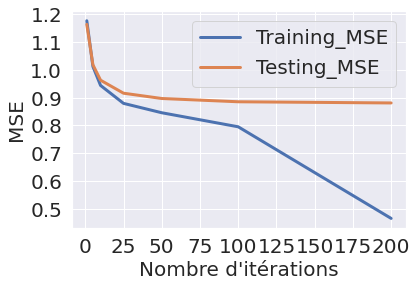

In [ ]:
plot_mse(range(birdi.n_iters), birdi)

In [ ]:
print('La matrice d\'évaluation après complétion')
print('')
birdi.all_rating_prediction()

La matrice d'évaluation après complétion



array([[3.19701837, 3.45006603, 3.10955555, ..., 3.28054947, 3.34017579,
        3.34599149],
       [4.21078539, 3.57749846, 3.17084016, ..., 3.68590512, 3.69492168,
        3.65016211],
       [3.34471953, 2.91499348, 2.65790332, ..., 3.11992054, 3.11319444,
        3.06183409],
       ...,
       [4.52376836, 3.72628327, 3.32523694, ..., 3.79895614, 3.79215072,
        3.77021019],
       [4.31012248, 3.78118243, 3.42344439, ..., 3.92126548, 3.92540358,
        3.87776333],
       [3.67246363, 3.18796169, 2.98273505, ..., 3.28348045, 3.29884059,
        3.26865994]])

Comme nous nous y attendions, avec l'algorithme de descente de gradient stochastique, les paramètres de notre modèle s'affinent au fil du temps. Nous avons choisi au hasard au début ces paramètres. L'une des premières observations que nous avons faites est l'influence du nombre de facteurs latents sur notre modèle. Avec des facteurs latents de tailles différentes, on a constaté que l'erreur de prédiction variait considérablement.

Nous avons trouvé un score RMSE égal à $\textbf{0.88}$. À titre indicatif, celui de Netflix lors du challenge de 2007 était de l'ordre de $0.95$

#Completion matricielle par optimisation convexe

Nous allons utiliser la bibliothèque **fancyimpute** pour la complétion matricielle. La bibliothèque contient des algorithmes de completion matricielle par optimisation convexe. Cette partie est différente de la factorisation matricielle. Voir **Matrix Completion Via Convex Optimization** de **E Candès** ou le pdf Recommender_filtrage_collaboratif dans le dossier Recommender_System

In [ ]:
import random
import math
import itertools

import numpy as np
from cvxpy import *

In [ ]:
pip install fancyimpute

In [ ]:
haha = ratings_matrix.astype('float')
haha[haha == 0] = 'nan' # or use np.nan
haha

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [ ]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


In [ ]:
X_incomplete_normalized = BiScaler().fit_transform(haha)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

[BiScaler] Initial log residual value = 10.300311
[BiScaler] Iter 1: log residual = 2.109617, log improvement ratio=8.190694
[BiScaler] Iter 2: log residual = 2.730659, log improvement ratio=-0.621043
[SoftImpute] Max Singular Value of X_init = 47.368426
[SoftImpute] Iter 1: observed MAE=0.055487 rank=848
[SoftImpute] Iter 2: observed MAE=0.055061 rank=776
[SoftImpute] Iter 3: observed MAE=0.054581 rank=726
[SoftImpute] Iter 4: observed MAE=0.054117 rank=685
[SoftImpute] Iter 5: observed MAE=0.053695 rank=655
[SoftImpute] Iter 6: observed MAE=0.053299 rank=628
[SoftImpute] Iter 7: observed MAE=0.052937 rank=604
[SoftImpute] Iter 8: observed MAE=0.052605 rank=586
[SoftImpute] Iter 9: observed MAE=0.052305 rank=568
[SoftImpute] Iter 10: observed MAE=0.052021 rank=553
[SoftImpute] Iter 11: observed MAE=0.051746 rank=538
[SoftImpute] Iter 12: observed MAE=0.051504 rank=527
[SoftImpute] Iter 13: observed MAE=0.051291 rank=515
[SoftImpute] Iter 14: observed MAE=0.051087 rank=504
[SoftImpute]

In [ ]:
missing_mask = np.random.rand(*haha.shape) < 0.1
missing_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False,  True],
       [False, False, False, ...,  True, False, False]])

In [ ]:
softImpute_mse = ((X_filled_softimpute[missing_mask] - ratings_matrix[missing_mask]) ** 2).mean()
print("Matrix Completion MSE: %f" % softImpute_mse)

Matrix Completion MSE: 0.853624
